# 311 Call Prediction - weekly

## what is 311?
##### 311 is a national service in the United States and in Canada that provides information about non-emergency municipal services. The service allows you to report that the trash collectors did not arrive to take your garbage or to find out how to get leaves and shrubs removed from the common area in front of your residence. The volume of calls to 311 vary, but in large cities and municipalities, it can range from thousands to tens of thousands of calls per month.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as tfv
import csv
import time
import functools
from sklearn.model_selection import train_test_split

# Data Wrangling - not really fun

In [2]:
def read(filename, date_idx, date_parse, year = None, bucket = 7):
    days_in_year = 365

    freq = {}

    if year != None:
        for period in range(int(days_in_year/bucket)):
            freq[period] = 0


    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        for row in csvreader:
            if row[date_idx] == '':
                continue

            t = time.strptime(row[date_idx], date_parse)
            if year == None:
                if not t.tm_year in freq:
                    freq[t.tm_year] = {}
                    for period in range(0, int(days_in_year/bucket)):
                        freq[t.tm_year][period] = 0
                if t.tm_yday < (days_in_year-1):
                    freq[t.tm_year][int(days_in_year/bucket)] += 1

            else:
                if t.tm_year == year and t.tm_yday < (days_in_year-1):
                    freq[int(t.tm_yday / bucket)] += 1

    return freq

In [19]:
def split_dataset(x_dataset,y_dataset, ratio):
    x_train,x_test,y_train,y_test = train_test_split(
        x_dataset,
        y_dataset,
        train_size=ratio
    )

    return x_train,x_test,y_train,y_test

# READING THE 311 Data

In [3]:
freq = read("311.csv.csv",1,"%m/%d/%Y %H:%M:%S %p", 2014)

In [4]:
print("shape of the Data: ",len(freq))

shape of the Data:  52


In [5]:
x_train = np.asarray(list(freq.keys()))
y_train = np.asarray(list(freq.values()))
maxY = np.max(y_train)
ny_train = y_train / maxY

In [6]:
print("Num samples: ",str(len(x_train)))

Num samples:  52


In [25]:
print("data: ", freq)

data:  {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 11007, 22: 40636, 23: 42519, 24: 43107, 25: 42245, 26: 38769, 27: 42352, 28: 41406, 29: 39419, 30: 36438, 31: 39173, 32: 37408, 33: 37354, 34: 27074, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0}


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")

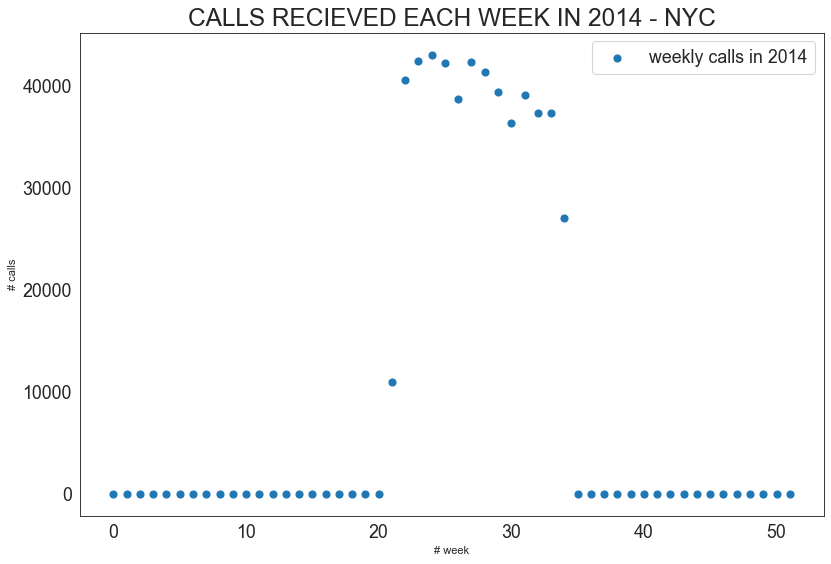

In [24]:
plt.figure(
    figsize=(12,8),
    dpi=80,
    facecolor="w",
    edgecolor="k"
)

plt.scatter(x_train,y_train,s=40,label="weekly calls in 2014")
plt.gca().set(xlabel = "# week", ylabel="# calls")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("CALLS RECIEVED EACH WEEK IN 2014 - NYC", fontsize=22)
plt.legend(fontsize=16,loc="best")

In [28]:
learning_rate = 1.5
training_epochs = 5000

In [10]:
tfv.disable_eager_execution()

In [11]:
X = tfv.placeholder(
    tf.float32
)
Y = tfv.placeholder(tf.float32)

In [12]:
def model(X,mu,sigma):
    return tf.exp(tfv.div(tf.negative(tf.pow(tf.subtract(X, mu), 2.)), tf.multiply(2., tf.pow(sigma, 2.))))

In [13]:
mu = tf.Variable(1., name="mu")
sigma = tf.Variable(1., name = "sigma")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
y_model = model(X,mu,sigma)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
cost = tf.pow(tf.subtract(y_model,Y),2)

In [30]:
train_op = tfv.train.GradientDescentOptimizer(learning_rate).minimize(cost)
from tqdm.notebook import tqdm

In [31]:
sess = tfv.Session()
init = tfv.global_variables_initializer()
sess.run(init)
for epoch in tqdm(range(training_epochs)):
    for (x,y) in zip(x_train,ny_train):
        sess.run(train_op,feed_dict={X:x,Y:y})


mu_val = sess.run(mu)
sig_val = sess.run(sigma)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [32]:
print("mean: ",mu_val)
print("std: ",sig_val)

mean:  27.231413
std:  4.9024706


In [34]:
# Closing the session:
sess.close()

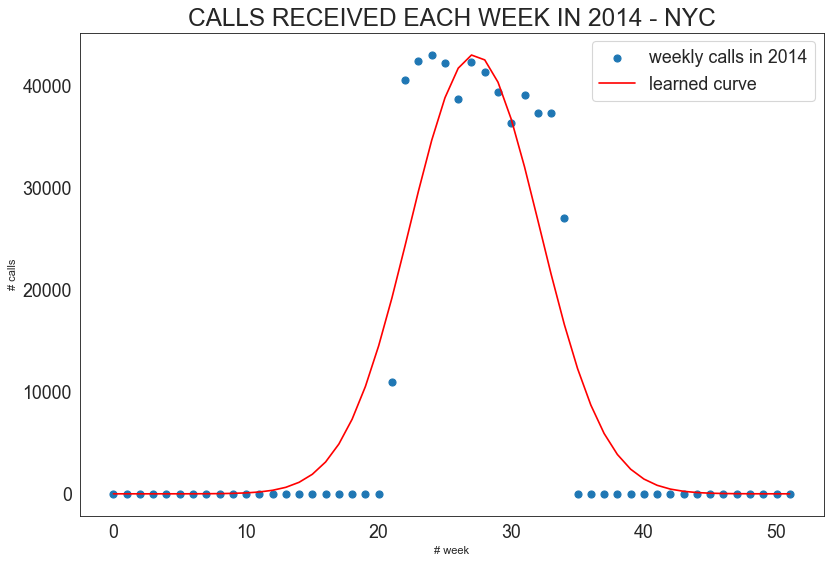

In [41]:
# plotting again:
plt.figure(
    figsize=(12,8),
    dpi=80,
    facecolor="w",
    edgecolor="k"
)



plt.scatter(x_train,y_train,s=40,label="weekly calls in 2014")
try2 = maxY * (np.exp(-np.power(x_train-mu_val,2.) / (2 * np.power(sig_val,2.))))
plt.plot(x_train,try2,label = "learned curve" , color = "r")
plt.gca().set(xlabel = "# week", ylabel="# calls")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("CALLS RECEIVED EACH WEEK IN 2014 - NYC", fontsize=22)
plt.legend(fontsize=16,loc="best")

Text(0.5, 1.0, 'Error')

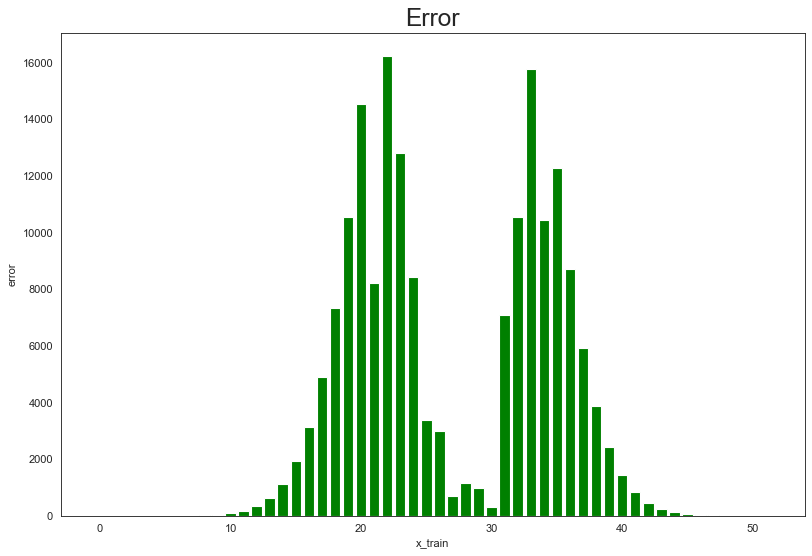

In [47]:
#plotting the error:
error = np.power(np.power(try2-y_train,2.),0.5)
plt.figure(
    figsize=(12,8),
    dpi=80,
    facecolor="w",
    edgecolor="k"
)



plt.bar(x_train,error,label="Error", color='g')
plt.gca().set(xlabel = "x_train",ylabel = "error")
plt.title("Error", fontsize=22)

In [48]:
avg_error = functools.reduce(lambda a,b: a+b, (try2-y_train))
avg_error = np.abs(avg_error) / len(x_train)
print("Avg ERROR: ",str(avg_error))

Avg ERROR:  208.08780826074533


In [49]:
acc = 1. - (avg_error/maxY)
print("Accuracy is: ", str(acc))

Accuracy is:  0.9951727606128762
